In [85]:
import numpy as np
import matplotlib.pyplot as plt
import numba as njit
import scipy as sp

# 8) Interpolation, Win a PRIZE at the end
Instructions
- Trace the movement of electrons in the electromagnetic potential from the last exercise with an integrator (Leapfrog, RK4). Use bilinear interpolation for the potential.
- The domain has the size of 0.01m in both dimensions, the electrons start at x=0 and y=0.007...0.009. The detector is at x=0.01 and y=0.001...0.003.
- Create a plot showing the paths of the electrons in the potential.
- Create histograms showing the arrival time and arrival position distribution.
- Use bicubic interpolation and check if this makes any difference.
- Then, use this to design an optimal electron detector. 
Optimize the detector design such that the most electrons hit the detector and the scatter in flight time is the smallest.

In [86]:
class Electron:
    def __init__(self, initial_position, initial_velocity):
        self.mass = 9.11 * 10**(-31) # kg
        self.charge = -1.6 * 10**(-19) # Coulomb
        self.positions = [np.array(initial_position)]
        self.velocities = [np.array(initial_velocity)]
        self.velocity = 1e6
        self.alive = True # aka in the detector
        self.time_alive = 0

        ## use this code to generate the velocities for the things
        v = 1e6 #m/s
        vy = np.random.uniform(-v,v,1)
        vx = np.sqrt(np.ones(1)*v**2-vy**2)

    def get_x_positions(self):
        return [pos[0] for pos in self.positions]

    def get_y_positions(self):
        return [pos[1] for pos in self.positions]

In [ ]:

class VoltageGrid:
    def __init__(self, size=25, width=0.001, voltage=1000, w_value=1.6735835835835835):
        self.size = size
        self.width = width
        self.voltage = voltage
        self.w_value = w_value

        self.x = np.linspace(0, self.width, self.size)
        self.y = np.linspace(0, self.width, self.size)

        self.setup_grid()
        self.simulate_grid()
        self.interpolate()

    """
    Sets up the basic grid, without doing the calculations

    the grid will be of given size with a stick at the locatin given by stick_location
    """
    def setup_grid(self):

        # create the default grid with 0 at the edges and 1000 in the center
        basic_matrix = np.zeros((self.size, self.size))

        # define the points in the grid, where our voltage lies
        voltage_grid = np.zeros_like(basic_matrix, dtype=bool)
        unvoltage_grid = np.zeros_like(basic_matrix, dtype=bool)

        """This is just a center position"""
        #voltage_grid[12, 12] = True

        """Stick in the middle from last weeks exercise"""
        #voltage_grid[int(self.size / 2), int(self.size / 4):int(self.size / 4 + self.size / 2)] = True

        """Stick down the diagonal"""
        #for i in range(1, self.size - 1):
        #    voltage_grid[self.size -1 - i, i] = True
        #voltage_grid[4:14, 49] = True

        """Test"""
        voltage_grid[34:44, 2] = True
        voltage_grid[4:14, 49] = True

        # define the bounds of our array
        bounds = np.zeros_like(basic_matrix, dtype=bool)
        bounds[0, :] = True
        bounds[-1, :] = True
        bounds[:, 0] = True
        bounds[:, -1] = True

        # define our update mask
        self.update_mask = np.ones_like(basic_matrix, dtype=bool)
        self.update_mask[voltage_grid] = False
        self.update_mask[unvoltage_grid] = False
        self.update_mask[bounds] = False

        # define our grid
        self.grid = np.zeros_like(basic_matrix)
        self.grid[voltage_grid] = self.voltage
        self.grid[unvoltage_grid] = -1 *  self.voltage

    """
    Runs the simulation for the grid using sor and the checkerboard implementation, we used in the last exercise.
    The grid positions will then have the voltage value for when the change in values drops below the treshhold
    """
    def simulate_grid(self, threshhold=10**-3, max_iterations=1000000):

        # create the needed help components for this
        update_matrix = np.zeros_like(self.grid)
        diff_matrix = self.grid - update_matrix
        W = np.array([[0,1,0],[1,-4,1],[0,1,0]])

        # compute the checkerboard pattern
        checkerboard = np.indices((self.size, self.size)).sum(axis=0) % 2 == 0

        diff = 1 + threshhold
        current_iteration = 0

        while diff > threshhold and current_iteration <= max_iterations:

            # calculate the update for the first time
            sp.ndimage.convolve(self.grid, W, output=update_matrix, mode="constant", cval=0)
            update_matrix *= self.w_value / 4
            update_matrix[~self.update_mask] = 0 # exclue the bounds and the stick from the update

            # update our matrix
            self.grid[checkerboard] = self.grid[checkerboard] + update_matrix[checkerboard]

            # calculate the stuff the second time
            sp.ndimage.convolve(self.grid, W, output=update_matrix, mode="constant", cval=0)
            update_matrix *= self.w_value / 4
            update_matrix[~self.update_mask] = 0 # exclue the bounds and the stick from the update

            self.grid[~checkerboard] = self.grid[~checkerboard] + update_matrix[~checkerboard]

            diff = np.max(np.abs(update_matrix[self.update_mask]))
            current_iteration += 1

    """
    Using the calculated grid, this function does two things:
    1. It uses numpy.gradient to compute the gradient using the given point values across the grid
    2. Since our particle will be able to fall between the grid positions, we use scipy.interpolate.RegularGridInterpolator
    to get a function out of the calculated gradient points
    """
    def interpolate(self):
        self.grad_grid_y, self.grad_grid_x = np.gradient(self.grid, self.width / self.size)

        # because I want a function because our electron can also lie inbetween points so we need to interpolate these points
        # one could do this by hand -> but one can also enjoy life
        self.gradient_x = sp.interpolate.RegularGridInterpolator((self.x, self.y), self.grad_grid_x)
        self.gradient_y = sp.interpolate.RegularGridInterpolator((self.x, self.y), self.grad_grid_y)

    """
    uses the defined window, to see if the electron was detected by the machine before leaving the machine
    returns true if the electron was detected and false if it left the machine outside of the detector
    """
    def check_electron_detection(self, electron):
        x, y = electron.positions[-1]
        # basically the electorn has to be on the right hand side of the detector and in the detection window on the bottom
        return x >= self.width and 0.0001 <= y <= 0.0003




    """
    Given a position, this function will return the gradient corresponding to the position

    #TODO This function throws an error if the position is outside of the bounds
    """
    def get_gradient(self, position):
        temp = self.gradient_x(position)
        temp2 = self.gradient_y(position)
        return np.array([self.gradient_x(position)[0], self.gradient_y(position)[0]])

    """
    Given the position, charge and mass of a particle, this function will return the acceleration on this particle
    the acceleration is calculated using the formula described in the lecture where
    acc = - (charge/mass) * gradient

    #TODO This function throws an error if the position is outside of the bounds
    """
    def calculate_acceleration(self, position, charge, mass):
        acceleration = -1 * (charge / mass) * self.get_gradient(position)
        return acceleration

    """
    Simply checks if the given position is in the grid
    """
    def is_position_in_grid(self, position):
        return (0 <= position[0] <= self.width) and (0 <= position[1] <= self.width)

    """
    Function used to vizualize the gradient using matplotlib
    """
    def visualize_gradient(self):
        ax.quiver(self.x, self.y, self.grad_grid_x, self.grad_grid_y, alpha=1)


    """
    Functin used to visualize the acceleration on the electron using matplolib
    used to find the best layout for the detector
    """
    def visualize_acceleration_on_electron(self):
        mass = 9.11 * 10**(-31) # kg
        charge = -1.6 * 10**(-19) # Coulomb

        x_accel = np.zeros_like(self.grad_grid_x)
        y_accel = np.zeros_like(self.grad_grid_y)

        for i in range(len(self.x)):
            for j in range(len(self.y)):
                acceleration = self.calculate_acceleration([self.x[i], self.y[j]], charge, mass)
                x_accel[i, j] = acceleration[0]
                y_accel[i, j] = acceleration[1]

        ax.quiver(self.x, self.y, x_accel, y_accel)
    
    """
    Function used to visualize the grid using matplotlib
    """
    def visualize_grid(self):
        CPF = ax.contourf(self.x, self.y, self.grid, alpha=0.3)


In [88]:
class ElectronSimulation():
    def __init__(self, grid, number_of_electrons, time_step=10**-12, width=0.01):
        self.grid = grid
        self.electron_velocity = 1e6
        self.electrons = []
        self.time_step = time_step
        self.width = width

        # generate the positions for the electrons
        # we simply line the number of electrons up in a single line and then shoot them
        y = np.linspace(0.0007, 0.0009, number_of_electrons)

        # y velocities are given at random, since this does not really matter
        yv = np.random.uniform(-self.electron_velocity, self.electron_velocity, number_of_electrons)
        # we make sure all electrons fly off in the same direction
        xv = np.sqrt(np.ones(1)*self.electron_velocity**2-yv**2) 

        for i in range(number_of_electrons):
            self.electrons.append(Electron(np.array([0, y[i]]), np.array([xv[i], yv[i]])))

    """
    This function calculates a single leapfrog step for any given electron,
    here we check the position of the particle twice to make sure, that it is still in the grid
    if not => the particle is set to dead (meaning out of bounds) and we stop calculating its position
    """
    def single_leapfrog_step(self, electron):

        # first drift step
        p_n_plus_half = electron.positions[-1] + self.time_step / 2 * electron.velocities[-1]

        # we need to validate, that the electron is still in the grid after this half step
        if(not self.grid.is_position_in_grid(p_n_plus_half)):
            # beeing here means the electron escaped the matrix somehow
            electron.alive = False
            electron.positions.append(p_n_plus_half) # since we want to store all positions of the electrons
            electron.time_alive += self.time_step / 2
            return np.array([0, 0]), np.array([0, 0])


        # kicks step
        acceleration = self.grid.calculate_acceleration(p_n_plus_half, electron.charge, electron.mass)
        v_n_plus_1 = electron.velocities[-1]

        # TODO Figure out, why we have to swap the coordinates for this to work
        # TODO -> This does not make sense at fucking all but anyway -> on to better things
        v_n_plus_1[0] += self.time_step * acceleration[1]
        v_n_plus_1[1] += self.time_step * acceleration[0]

        # second drift step
        p_n_plus_1 = p_n_plus_half + self.time_step/2 * v_n_plus_1

        if(not self.grid.is_position_in_grid(p_n_plus_1)):
            electron.alive = False

        electron.positions.append(p_n_plus_1)
        electron.velocities.append(v_n_plus_1)
        electron.time_alive += self.time_step

        return p_n_plus_half, acceleration

    """
    This function simulates the electron path from start to finish
    we do this for a single electron
    """
    def simulate_electron_path(self, electron, max_iterations=10000):
        current_iteration = 0
        while electron.alive and current_iteration <= max_iterations:
            # update the position of the electron
            pos, accel = self.single_leapfrog_step(electron)
            current_iteration += 1


    def simulate_electrons(self):
        for e in self.electrons:
            self.simulate_electron_path(e)

In [89]:
# run the simulation and do the analysis
size = 50
number_of_electrons = 5

grid = VoltageGrid(size=size, voltage=1000)
electron_simulation = ElectronSimulation(grid, number_of_electrons)
electron_simulation.simulate_electrons()

detected_electrons = []
undetected_electrons = []
for e in electron_simulation.electrons:
    if(grid.check_electron_detection(e)):
        detected_electrons.append(e)
    else:
        undetected_electrons.append(e)

print(f"Detected: {(len(detected_electrons)*100 / number_of_electrons):.0f}")
print(f"Undetected: {(len(undetected_electrons)*100 / number_of_electrons):.0f}")

Detected: 0
Undetected: 100


/var/folders/63/kr3r0_q93cs_34zrsvflw69r0000gn/T/ipykernel_47348/513663969.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


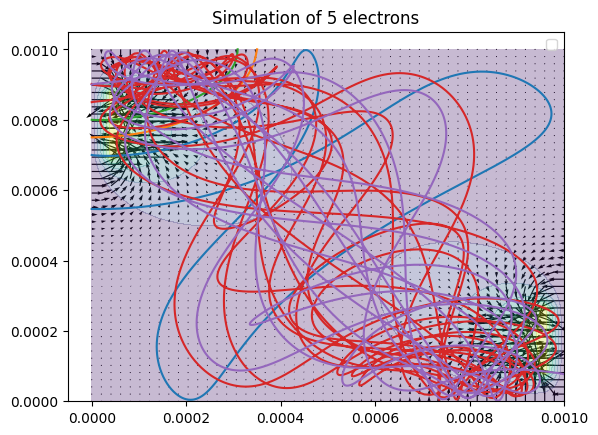

'\nNote to selfe: The entire grid is wrong, x and y are opposited\n'

<Figure size 640x480 with 0 Axes>

In [90]:
fix, ax = plt.subplots()


# visualize the grid and the gradient
grid.visualize_gradient()
grid.visualize_grid()

for e in electron_simulation.electrons:
    plt.plot(e.get_x_positions(), e.get_y_positions())

plt.title(f"Simulation of {number_of_electrons} electrons")
plt.legend()
plt.show()


# plot of the distribution of the arrival time
plt.clf()
"""
Note to selfe: The entire grid is wrong, x and y are opposited
"""